<a href="https://colab.research.google.com/github/samiraabnar/attention_flow/blob/master/bert_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [66]:
# %pip install transformers

In [67]:
# from google.colab import drive
# drive.mount('/content/gdrive')

In [68]:
# %ls

In [69]:
# !git clone https://github.com/samiraabnar/attention_flow

In [70]:
# %cd gdrive/My Drive/attention_flow/

In [71]:
%pip install tensorflow_datasets

Note: you may need to restart the kernel to use updated packages.


In [85]:
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
from attention_graph_util import *
import seaborn as sns
import itertools 
import matplotlib as mpl

rc={'font.size': 10, 'axes.labelsize': 10, 'legend.fontsize': 10.0, 
    'axes.titlesize': 32, 'xtick.labelsize': 20, 'ytick.labelsize': 16}
plt.rcParams.update(**rc)
mpl.rcParams['axes.linewidth'] = .5 #set the value globally

import torch
import matplotlib.pyplot as plt

# Importando apenas o que importa, sem o "*"
from transformers import (
    BertConfig, 
    BertForMaskedLM, 
    BertTokenizer,
    BertModel, 
    OpenAIGPTModel, OpenAIGPTTokenizer,
    GPT2Model, GPT2Tokenizer,
    CTRLModel, CTRLTokenizer,
    XLNetModel, XLNetTokenizer,
    XLMModel, XLMTokenizer,
    DistilBertModel, DistilBertTokenizer,
    RobertaModel, RobertaTokenizer,
    BertForPreTraining, BertForNextSentencePrediction,
    BertForSequenceClassification, BertForTokenClassification, 
    BertForQuestionAnswering,
    AutoModelForCausalLM, AutoTokenizer
)


def plot_attention_heatmap(att, s_position, t_positions, tokens_list):
    cls_att = np.flip(att[:, s_position, t_positions], axis=0)
    
    xticklb = [tokens_list[i] for i in t_positions]
    yticklb = [str(i) if i%2 ==0 else '' for i in np.arange(att.shape[0],0, -1)]
    
    ax = sns.heatmap(cls_att, xticklabels=xticklb, yticklabels=yticklb, cmap="YlOrRd")
    return ax


def convert_adjmat_tomats(adjmat, n_layers, l):
   mats = np.zeros((n_layers,l,l))
   
   for i in np.arange(n_layers):
       mats[i] = adjmat[(i+1)*l:(i+2)*l,i*l:(i+1)*l]
       
   return mats


In [86]:
pretrained_weights = 'gpt2'
model = AutoModelForCausalLM.from_pretrained(pretrained_weights,
                                             output_hidden_states=True,
                                             output_attentions=True)
model.zero_grad()
tokenizer = AutoTokenizer.from_pretrained(pretrained_weights, use_fast=True)


Loading weights: 100%|██████████| 148/148 [00:00<00:00, 267.89it/s, Materializing param=transformer.wte.weight]             
GPT2LMHeadModel LOAD REPORT from: gpt2
Key                  | Status     |  | 
---------------------+------------+--+-
h.{0...11}.attn.bias | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


In [87]:
sentences = {}

sentences[0] = "He talked to her about his book"

sentences[1] = "She asked the doctor about "+" backache"

sentences[2] = "The author talked to Sara about his"

sentences[3] = "John tried to convince Mary of his love and brought flowers for "

sentences[4] = "Mary convinced John of "+" love"

sentences[5] = "Barack Obama was the president of the"

sentences[6] = "Artificial intelligence is the field of study that"

sentences[7] = "Why is the sky blue?"

sentences[8] = "If Paul's wife is Mary, Mary's husband is"


ex_id = 5
sentence = sentences[ex_id]

tokens =  tokenizer.tokenize(sentences[ex_id])
print(len(tokens), tokens)


# tokeniza a sentença
tf_input_ids = tokenizer.encode(sentence)
print(f"decoding: {tokenizer.decode(tf_input_ids)}")


# transforma em um batch de sentença única
input_ids = torch.tensor([tf_input_ids])


# saída no formato codificado: 1(batch), L(sentença), V (Vocab)
model_outputs = model(input_ids)

# pega as atenções e hidden_states 12 Camadas, 1(batch), 12 (cabeças) , L(sentença), L(sentença)
all_hidden_states, all_attentions =  model_outputs['hidden_states'], model_outputs['attentions'] 

# transforma cada camada em array para poder operar depois
_attentions = [att.detach().numpy() for att in all_attentions] # transforma em array
print(len(_attentions)) # (12,1,12,L,L)
# 12 camadas, 1 batch, 12 cabeças, LXL

# mata a camada de batch
attentions_mat = np.asarray(_attentions)[:,0]
print(attentions_mat.shape)

8 ['Bar', 'ack', 'ĠObama', 'Ġwas', 'Ġthe', 'Ġpresident', 'Ġof', 'Ġthe']
decoding: Barack Obama was the president of the
12
(12, 12, 8, 8)


In [88]:
print(input_ids)
print(tokens)

output_ids = model.generate(input_ids, max_length=30)

print(tokenizer.decode(output_ids[0], skip_special_tokens=True))

output = model(input_ids).logits[0] # pega logits da saída
# print(len(output), output.shape, src[ex_id], output[0, src[ex_id]].shape)
# output = [model(id)[0] for id in input_ids]

#softmask da coluna com mask
predicted_target = torch.nn.Softmax(dim=0)(output[-1,:])

# converte para array e pega o argmax(maior logit) para o último token
previewd = np.argmax(predicted_target.detach().numpy(), axis=-1)
top5 = np.argsort(predicted_target.detach().numpy())[-5:]

print(np.argsort(predicted_target.detach().numpy())[-5:][::1])
print(tokenizer.decode(previewd), previewd) 


# pega top5 mais provaveis para plotar
yax = [float(predicted_target[id].detach()) for id in top5]
xax = [tokenizer.decode(id) for id in top5] 
print(yax, xax)

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


tensor([[10374,   441,  2486,   373,   262,  1893,   286,   262]])
['Bar', 'ack', 'ĠObama', 'Ġwas', 'Ġthe', 'Ġpresident', 'Ġof', 'Ġthe']
Barack Obama was the president of the United States. He was the first African-American president. He was the first African-American president of the
[1605 1294 2059  471 1578]
 United 1578
[0.010948844254016876, 0.011176892556250095, 0.012958399951457977, 0.016767624765634537, 0.700174868106842] [' American', ' US', ' University', ' U', ' United']


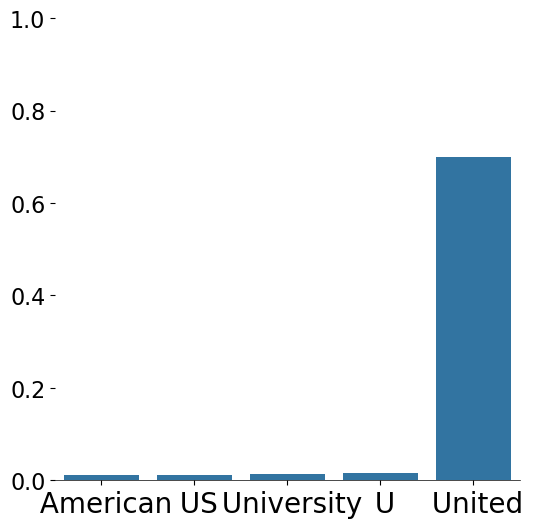

In [90]:
fig = plt.figure(1,figsize=(6,6))
ax = sns.barplot(x= xax, y=yax, linewidth=0
)
sns.despine(fig=fig, ax=None, top=True, right=True, left=True, bottom=False, offset=None, trim=False)
ax.set_ylim(0,1)
plt.savefig('rat_bert_bar_{}.png'.format(ex_id), format='png', transparent=True, dpi=360, bbox_inches='tight')

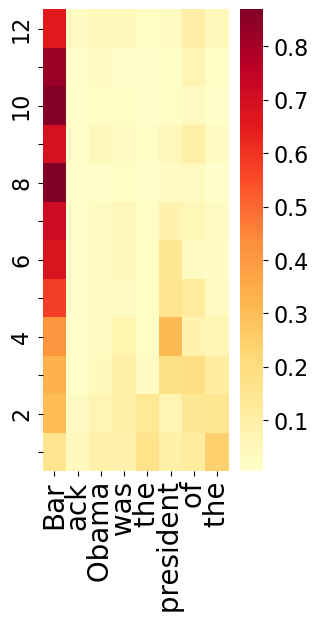

In [92]:
plt.figure(2,figsize=(3,6))
#soma no eixo das cabeças e tira a média
# passa onde está o mask
# passa t e sentença
# print(attentions_mat.sum(axis=1)/attentions_mat.shape[1])

# basicamente, quanto o s presta atenção aos outros tokens
# é possível ver o automasking

tokens_list = [tokenizer.decode(id) for id in tf_input_ids]

t_list=[]
for i in range(len(tokens)):
    t_list.append(i)
t_pos= tuple(t_list)
plot_attention_heatmap(attentions_mat.sum(axis=1)/attentions_mat.shape[1], s_position=len(tf_input_ids)-1, t_positions=t_pos, tokens_list=tokens_list)

#raw attention
plt.savefig('rat_bert_att_{}.png'.format(ex_id), format='png', transparent=True, dpi=360, bbox_inches='tight')

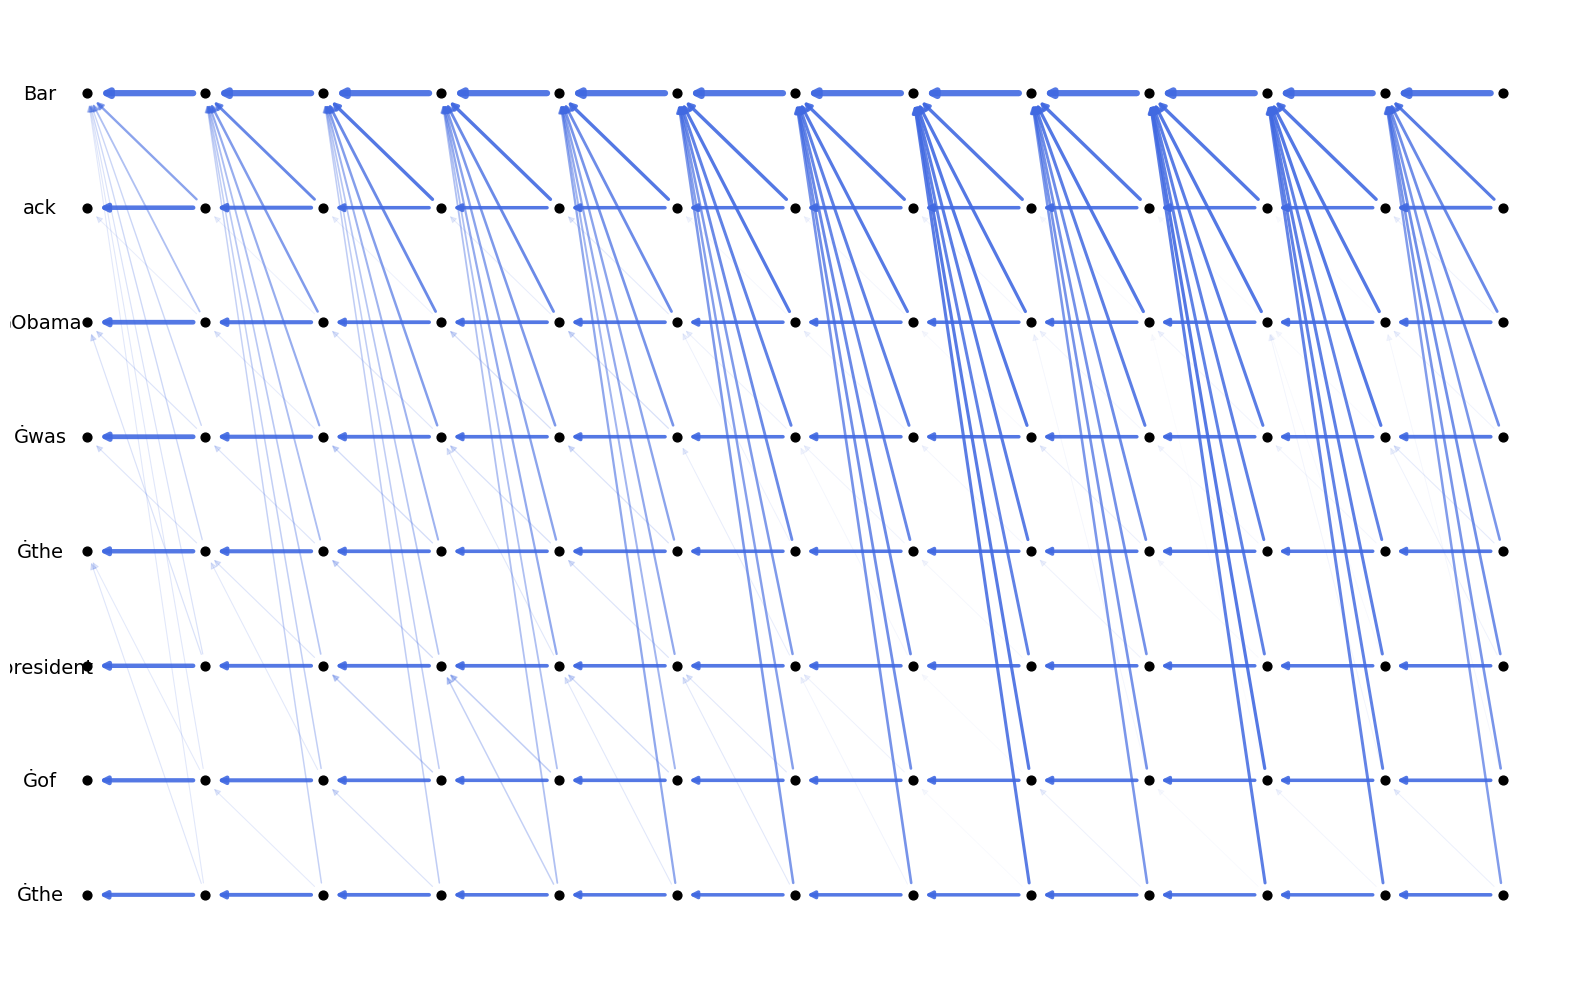

In [93]:
res_att_mat = attentions_mat.sum(axis=1)/attentions_mat.shape[1]

res_att_mat = res_att_mat + np.eye(res_att_mat.shape[1])[None,...]

# renormaliza, mesma coisa de dividir por dois
res_att_mat = res_att_mat / res_att_mat.sum(axis=-1)[...,None]

# [[0, 0, 0, ..., 0]]
# [[W1, 0, 0, ..., 0]]
# [[0, W2, 0, ..., 0]]
# [[0, 0, 0, ..., Wn, 0]]
res_adj_mat, res_labels_to_index = get_adjmat(mat=res_att_mat, input_tokens=tokens)

res_G = draw_attention_graph(res_adj_mat,res_labels_to_index, n_layers=res_att_mat.shape[0], length=res_att_mat.shape[-1])

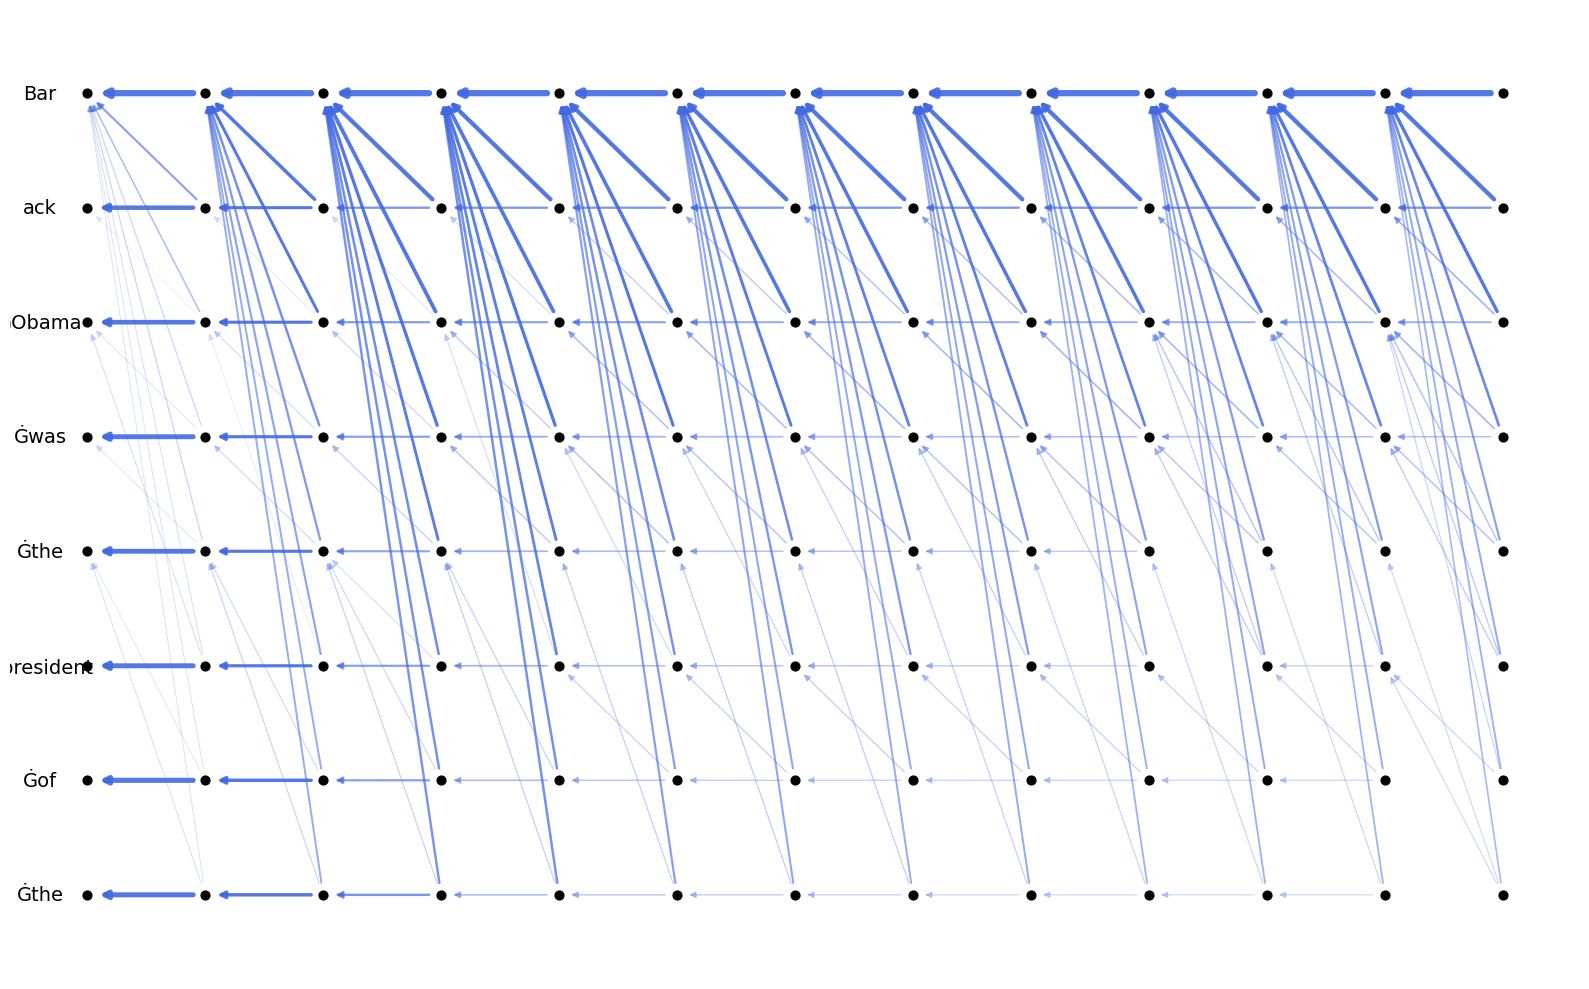

In [94]:
output_nodes = []
input_nodes = []
for key in res_labels_to_index:
    if 'L24' in key:
        # não entendi
        output_nodes.append(key)
    if res_labels_to_index[key] < attentions_mat.shape[-1]:
        input_nodes.append(key)

# import importlib
# import attention_graph_util as a
# importlib.reload(a)

# attention flow
# basta entender agora o algoritmo de max flow
flow_values = compute_flows(res_G, res_labels_to_index, input_nodes, length=attentions_mat.shape[-1])
flow_G = draw_attention_graph(flow_values,res_labels_to_index, n_layers=attentions_mat.shape[0], length=attentions_mat.shape[-1])

# dá para perceber também o masking, dado que os tokens só observam o passado, a concentração é maior nos tokens iniciais

(12, 8, 8)
(12, 8, 8)
['Bar', 'ack', ' Obama', ' was', ' the', ' president', ' of', ' the']


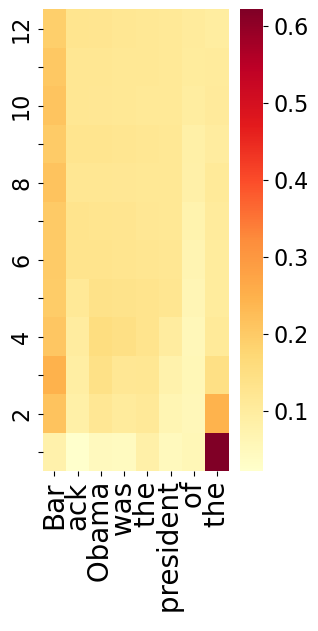

In [ ]:
flow_att_mat = convert_adjmat_tomats(flow_values, n_layers=attentions_mat.shape[0], l=attentions_mat.shape[-1])

print(flow_att_mat.shape)

plt.figure(3,figsize=(3,6))

plot_attention_heatmap(flow_att_mat, s_position=len(tf_input_ids)-1, t_positions=t_pos, sentenceax=tokens_list)

# attention flow
plt.savefig('res_fat_bert_att_{}.png'.format(ex_id), format='png', transparent=True,dpi=360, bbox_inches='tight')

(104, 104) 12 8


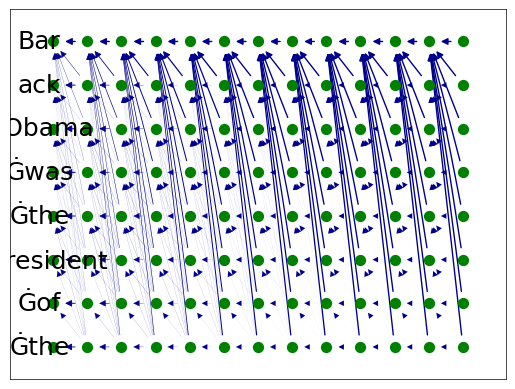

In [60]:
#attention rollout
joint_attentions = compute_joint_attention(res_att_mat, add_residual=False)

joint_att_adjmat, joint_labels_to_index = get_adjmat(mat=joint_attentions, input_tokens=tokens)

G = draw_attention_graph(joint_att_adjmat,joint_labels_to_index, n_layers=joint_attentions.shape[0], length=joint_attentions.shape[-1])

(12, 8, 8)
['Bar', 'ack', ' Obama', ' was', ' the', ' president', ' of', ' the']


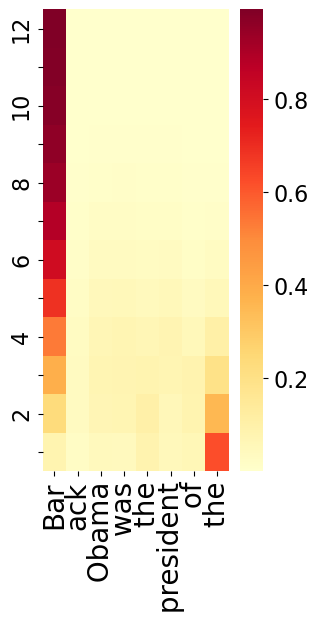

In [80]:
plt.figure(4,figsize=(3,6))
plot_attention_heatmap(joint_attentions, 7, t_positions=(0,1,2,3,4,5,6,7), sentenceax=sentenceax)
plt.savefig('res_jat_bert_att_{}.png'.format(ex_id), format='png', transparent=True, dpi=360, bbox_inches='tight')